<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
response

<Response [200]>

In [4]:
# json文字列をdictへ
j_res = json.loads(response.text)
j_res.keys()

dict_keys(['contacts', 'querents', 'patients', 'patients_summary', 'discharges_summary', 'inspections_summary', 'inspection_persons', 'inspection_status_summary', 'lastUpdate', 'main_summary'])

In [5]:
# 日毎の数
patients_count = [data['小計'] for data in j_res['patients_summary']['data']]

In [6]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [7]:
# 日付をインデックスにした日毎の数のデータフレーム
patients_df = pd.DataFrame(
    {'patients_count': patients_count},
    index=pd.date_range(
        start=utc_datestr_to_jst_date(j_res['patients_summary']['data'][0]['日付']),
        end=utc_datestr_to_jst_date(j_res['patients_summary']['data'][-1]['日付']),
        freq='D'))
patients_df['datetime'] = patients_df.index
patients_df.tail()

,patients_count,datetime
2020-08-01 17:00:00+09:00,472,2020-08-01 17:00:00+09:00
2020-08-02 17:00:00+09:00,292,2020-08-02 17:00:00+09:00
2020-08-03 17:00:00+09:00,258,2020-08-03 17:00:00+09:00
2020-08-04 17:00:00+09:00,309,2020-08-04 17:00:00+09:00
2020-08-05 17:00:00+09:00,263,2020-08-05 17:00:00+09:00


In [8]:
# 7日移動平均
seven_day_mov_ave = patients_df['patients_count'].rolling('7D').mean()
seven_day_mov_center_ave = patients_df['patients_count'].rolling(7, center=True).mean()
seven_day_mov_sum = patients_df['patients_count'].rolling('7D').sum()
patients_df['7d_mov_ave'] = seven_day_mov_ave
patients_df['7d_mov_center_ave'] = seven_day_mov_center_ave
patients_df['7d_mov_sum'] = seven_day_mov_sum
patients_df.tail()

,patients_count,datetime,7d_mov_ave,7d_mov_center_ave,7d_mov_sum
2020-08-01 17:00:00+09:00,472,2020-08-01 17:00:00+09:00,312.571429,344.428571,2188.0
2020-08-02 17:00:00+09:00,292,2020-08-02 17:00:00+09:00,320.142857,346.285714,2241.0
2020-08-03 17:00:00+09:00,258,2020-08-03 17:00:00+09:00,338.285714,NaN,2368.0
2020-08-04 17:00:00+09:00,309,2020-08-04 17:00:00+09:00,344.428571,NaN,2411.0
2020-08-05 17:00:00+09:00,263,2020-08-05 17:00:00+09:00,346.285714,NaN,2424.0


In [9]:
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
patients_df['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in patients_df.index]
patients_df.tail()

,patients_count,datetime,7d_mov_ave,7d_mov_center_ave,7d_mov_sum,week_num
2020-08-01 17:00:00+09:00,472,2020-08-01 17:00:00+09:00,312.571429,344.428571,2188.0,'20w31
2020-08-02 17:00:00+09:00,292,2020-08-02 17:00:00+09:00,320.142857,346.285714,2241.0,'20w31
2020-08-03 17:00:00+09:00,258,2020-08-03 17:00:00+09:00,338.285714,NaN,2368.0,'20w32
2020-08-04 17:00:00+09:00,309,2020-08-04 17:00:00+09:00,344.428571,NaN,2411.0,'20w32
2020-08-05 17:00:00+09:00,263,2020-08-05 17:00:00+09:00,346.285714,NaN,2424.0,'20w32


In [10]:
# 曜日の列をセット
patients_df['week_day'] = [d.strftime('%a') for d in patients_df.index]
patients_df.tail(15)

,patients_count,datetime,7d_mov_ave,7d_mov_center_ave,7d_mov_sum,week_num,week_day
2020-07-22 17:00:00+09:00,238,2020-07-22 17:00:00+09:00,242.857143,250.285714,1700.0,'20w30,Wed
2020-07-23 17:00:00+09:00,366,2020-07-23 17:00:00+09:00,254.285714,257.571429,1780.0,'20w30,Thu
2020-07-24 17:00:00+09:00,260,2020-07-24 17:00:00+09:00,249.571429,252.285714,1747.0,'20w30,Fri
2020-07-25 17:00:00+09:00,295,2020-07-25 17:00:00+09:00,250.285714,256.428571,1752.0,'20w30,Sat
2020-07-26 17:00:00+09:00,239,2020-07-26 17:00:00+09:00,257.571429,258.142857,1803.0,'20w30,Sun
2020-07-27 17:00:00+09:00,131,2020-07-27 17:00:00+09:00,252.285714,258.285714,1766.0,'20w31,Mon
2020-07-28 17:00:00+09:00,266,2020-07-28 17:00:00+09:00,256.428571,287.285714,1795.0,'20w31,Tue
2020-07-29 17:00:00+09:00,250,2020-07-29 17:00:00+09:00,258.142857,312.571429,1807.0,'20w31,Wed
2020-07-30 17:00:00+09:00,367,2020-07-30 17:00:00+09:00,258.285714,320.142857,1808.0,'20w31,Thu
2020-07-31 17:00:00+09:00,463,2020-07-31 17:00:00+09:00,287.285714,338.285714,2011.0,'20w31,Fri


In [11]:
# 週毎に集計
groupby_week_num = patients_df.groupby('week_num')
groupby_week_num

In [12]:
# 集計結果から平均と合計を取得しデータフレームにセット
week_num_df = pd.DataFrame({
    'week_num': patients_df['week_num'].unique(),
    'week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
week_num_df.tail()

,week_num,week_mean,week_sum
2020-07-12 17:00:00+09:00,'20w28,166.000000,1162
2020-07-19 17:00:00+09:00,'20w29,212.000000,1484
2020-07-26 17:00:00+09:00,'20w30,257.571429,1803
2020-08-02 17:00:00+09:00,'20w31,320.142857,2241
2020-08-05 17:00:00+09:00,'20w32,276.666667,830


In [13]:
df = pd.concat([
                patients_df,
                week_num_df.loc[:, ['week_mean', 'week_sum']]
                ], axis=1)
df.tail(15)

,patients_count,datetime,7d_mov_ave,7d_mov_center_ave,7d_mov_sum,week_num,week_day,week_mean,week_sum
2020-07-22 17:00:00+09:00,238,2020-07-22 17:00:00+09:00,242.857143,250.285714,1700.0,'20w30,Wed,NaN,NaN
2020-07-23 17:00:00+09:00,366,2020-07-23 17:00:00+09:00,254.285714,257.571429,1780.0,'20w30,Thu,NaN,NaN
2020-07-24 17:00:00+09:00,260,2020-07-24 17:00:00+09:00,249.571429,252.285714,1747.0,'20w30,Fri,NaN,NaN
2020-07-25 17:00:00+09:00,295,2020-07-25 17:00:00+09:00,250.285714,256.428571,1752.0,'20w30,Sat,NaN,NaN
2020-07-26 17:00:00+09:00,239,2020-07-26 17:00:00+09:00,257.571429,258.142857,1803.0,'20w30,Sun,257.571429,1803.0
2020-07-27 17:00:00+09:00,131,2020-07-27 17:00:00+09:00,252.285714,258.285714,1766.0,'20w31,Mon,NaN,NaN
2020-07-28 17:00:00+09:00,266,2020-07-28 17:00:00+09:00,256.428571,287.285714,1795.0,'20w31,Tue,NaN,NaN
2020-07-29 17:00:00+09:00,250,2020-07-29 17:00:00+09:00,258.142857,312.571429,1807.0,'20w31,Wed,NaN,NaN
2020-07-30 17:00:00+09:00,367,2020-07-30 17:00:00+09:00,258.285714,320.142857,1808.0,'20w31,Thu,NaN,NaN
2020-07-31 17:00:00+09:00,463,2020-07-31 17:00:00+09:00,287.285714,338.285714,2011.0,'20w31,Fri,NaN,NaN


### グラフ出力

In [14]:
### 日毎の数
x = df.index
y1_1 = df['patients_count']
y1_2 = df['7d_mov_ave']
#y1_3 = df['7d_mov_center_ave']
y1_4 = df['week_mean']

In [15]:
### 週毎の数
#x2 = week_num_df['week_num']
#y2_1 = week_num_df['week_mean']
#y2_2 = week_num_df['week_sum']
y2_1 = df['7d_mov_sum']
y2_2 = df['week_sum']

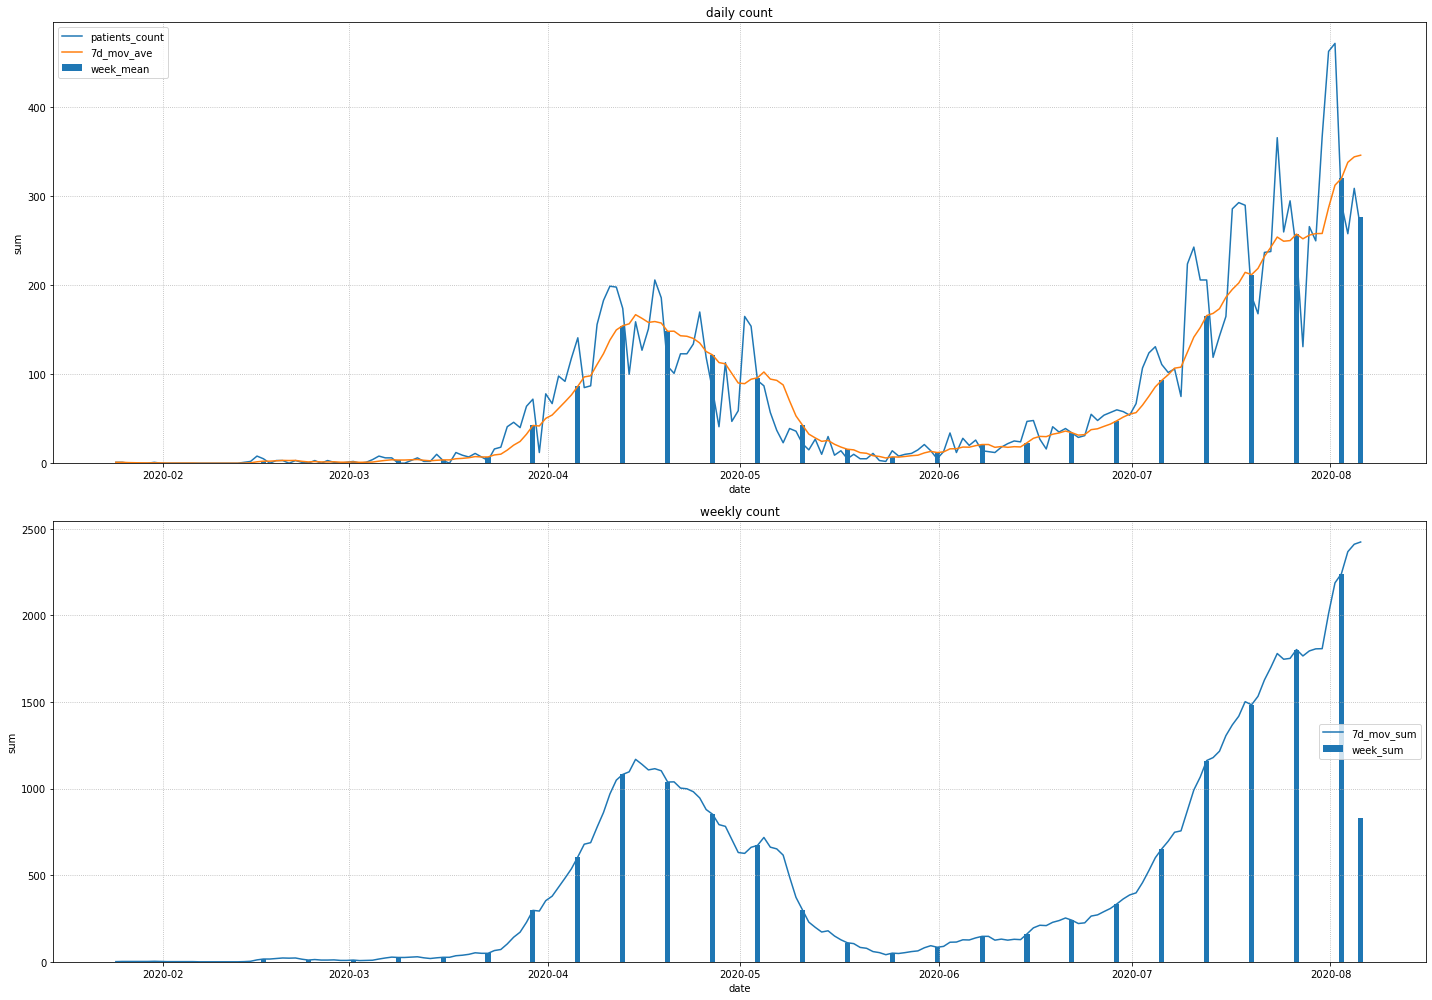

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(20, 14))

### 日毎の数
ax[0].set_title('daily count')
ax[0].set_xlabel('date')
ax[0].set_ylabel('sum')
ax[0].plot(x, y1_1, label='patients_count')
ax[0].plot(x, y1_2, label='7d_mov_ave')
#ax[0].plot(x, y1_3, label='7d_mov_center_ave')
ax[0].bar(x, y1_4, label='week_mean')
ax[0].grid(linestyle=':')
ax[0].legend()

### 週毎の平均
#ax[1].set_title('weekly mean')
#ax[1].set_xticklabels(labels=x2, rotation=90)
#ax[1].set_xlabel('week_num')
#ax[1].set_ylabel('mean')
#ax[1].plot(x2, y2_1, label='mean')
#ax[1].grid(linestyle=':')
#ax[1].legend()

### 週毎の合計
ax[1].set_title('weekly count')
ax[1].set_xlabel('date')
ax[1].set_ylabel('sum')
ax[1].plot(x, y2_1, label='7d_mov_sum')
ax[1].bar(x, y2_2, label='week_sum')
ax[1].grid(linestyle=':')
ax[1].legend()
#ax[1].set_title('weekly sum')
#ax[1].set_xticklabels(labels=x2, rotation=90)
#ax[1].set_xlabel('week_num')
#ax[1].set_ylabel('sum')
#ax[1].plot(x2, y2_2, label='sum')
#ax[1].grid(linestyle=':')
#ax[1].legend()

plt.tight_layout()

---

In [17]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [18]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [19]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [20]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [21]:
ds_df = pd.DataFrame({
    'year': df.index.strftime('%Y'), # 年
    'month': df.index.strftime('%m'), # 月
    'day': df.index.strftime('%d'), # 日
    'week_day': df['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
ds_df['passed'] = [(d - df['datetime'][0]).days for d in df['datetime']]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df['datetime']]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df['datetime']]
# 日毎の数
ds_df['patients_count'] = df['patients_count']
# 7日間移動平均
ds_df['7d_mov_ave'] = df['7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df['7d_mov_center_ave']
# 7日間移動合計
ds_df['7d_mov_sum'] = df['7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(120)

,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,patients_count,7d_mov_ave,7d_mov_sum
75,2020,04,08,0,0,0,0,0,0,1,75,1,1,156,111.000000,777.0
76,2020,04,09,0,0,0,0,1,0,0,76,1,2,183,123.142857,862.0
77,2020,04,10,1,0,0,0,0,0,0,77,1,3,199,138.428571,969.0
78,2020,04,11,0,0,1,0,0,0,0,78,1,4,198,149.857143,1049.0
79,2020,04,12,0,0,0,1,0,0,0,79,1,5,174,154.571429,1082.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,2020,08,01,0,0,1,0,0,0,0,190,0,116,472,312.571429,2188.0
191,2020,08,02,0,0,0,1,0,0,0,191,0,117,292,320.142857,2241.0
192,2020,08,03,0,1,0,0,0,0,0,192,0,118,258,338.285714,2368.0
193,2020,08,04,0,0,0,0,0,1,0,193,0,119,309,344.428571,2411.0


In [22]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            195 non-null    object 
 1   month           195 non-null    object 
 2   day             195 non-null    object 
 3   Fri             195 non-null    uint8  
 4   Mon             195 non-null    uint8  
 5   Sat             195 non-null    uint8  
 6   Sun             195 non-null    uint8  
 7   Thu             195 non-null    uint8  
 8   Tue             195 non-null    uint8  
 9   Wed             195 non-null    uint8  
 10  passed          195 non-null    int64  
 11  emergency       195 non-null    int64  
 12  em_passed       195 non-null    int64  
 13  patients_count  195 non-null    int64  
 14  7d_mov_ave      195 non-null    float64
 15  7d_mov_sum      195 non-null    float64
dtypes: float64(2), int64(4), object(3), uint8(7)
memory usage: 15.2+ KB


In [23]:
ds_df.describe()

,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,patients_count,7d_mov_ave,7d_mov_sum
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,0.143590,0.143590,0.143590,0.143590,0.138462,0.143590,0.143590,97.000000,0.251282,37.230769,73.256410,68.551868,479.779487
std,0.351576,0.351576,0.351576,0.351576,0.346273,0.351576,0.351576,56.435804,0.434867,40.162339,95.831606,85.380808,597.732569
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,48.500000,0.000000,0.000000,4.500000,3.714286,26.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,97.000000,0.000000,23.000000,28.000000,28.000000,196.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,145.500000,0.500000,71.500000,115.500000,109.500000,766.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,194.000000,1.000000,120.000000,472.000000,346.285714,2424.000000


In [24]:
ds_df.corr()

,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,patients_count,7d_mov_ave,7d_mov_sum
Fri,1.000000,-0.167665,-0.167665,-0.167665,-0.164153,-0.167665,-0.167665,-0.018185,-0.001210,-0.014406,0.066524,-0.018133,-0.018220
Mon,-0.167665,1.000000,-0.167665,-0.167665,-0.164153,-0.167665,-0.167665,0.003637,-0.001210,0.004212,-0.097025,0.006828,0.006848
Sat,-0.167665,-0.167665,1.000000,-0.167665,-0.164153,-0.167665,-0.167665,-0.010911,-0.001210,-0.008200,0.065453,-0.006578,-0.006643
Sun,-0.167665,-0.167665,-0.167665,1.000000,-0.164153,-0.167665,-0.167665,-0.003637,-0.001210,-0.001994,-0.019916,0.000527,0.000519
Thu,-0.164153,-0.164153,-0.164153,-0.164153,1.000000,-0.164153,-0.164153,0.000000,0.007373,-0.007128,0.043661,-0.018140,-0.018082
Tue,-0.167665,-0.167665,-0.167665,-0.167665,-0.164153,1.000000,-0.167665,0.010911,-0.001210,0.010418,-0.020834,0.014391,0.014427
Wed,-0.167665,-0.167665,-0.167665,-0.167665,-0.164153,-0.167665,1.000000,0.018185,-0.001210,0.016989,-0.037205,0.020831,0.020878
passed,-0.018185,0.003637,-0.010911,-0.003637,0.000000,0.010911,0.018185,1.000000,0.010292,0.946604,0.617587,0.640850,0.641017
emergency,-0.001210,-0.001210,-0.001210,-0.001210,0.007373,-0.001210,-0.001210,0.010292,1.000000,-0.191339,0.054230,0.133806,0.133872
em_passed,-0.014406,0.004212,-0.008200,-0.001994,-0.007128,0.010418,0.016989,0.946604,-0.191339,1.000000,0.609302,0.625953,0.626013
